<a href="https://colab.research.google.com/github/MahdiJahanbakht/MultiLabelImageClassification/blob/main/MultiClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import os
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
baseDir = './'
dataDir = baseDir + 'candidates/'
runDir = baseDir + 'Runs/'

# classes
class_names = os.listdir(dataDir)
class_names.sort()

for cls in class_names:
    addr = f'{cls}/'
    #filter .txt files for now
    files_in_directory = os.listdir(dataDir+addr)
    filtered_files = [file for file in files_in_directory if file. endswith(".txt")]
    for file in filtered_files:
        os.remove(dataDir + addr + file)

In [ ]:
baseDir = './'
dataDir = baseDir + 'Datasets/'
runDir = baseDir + 'Runs/'

# we used batch size of 64 images for batch learning
batch_size = 64


mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# For traing data we used Data Augmentation of the form of transforms that
# randomly rotate, scale and crop, then flip images
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_nums, std_nums))])

# For test data we did'nt use any form of Data Augmentation and just used
# resize and center crop to adjust our images for input
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((mean_nums, std_nums))])
# Define train and test folders located on google drive
trainset = datasets.ImageFolder(dataDir+'train', transform=train_transforms)
testset = datasets.ImageFolder(dataDir+'test',transform=test_transforms)

# Define batch loaders
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [ ]:
# Use Gpu if it's available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Download pre-trained model
model = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Design our desired classification layer
# LogSofmax goes with NLLLoss

classifier = nn.Sequential(OrderedDict([
                          ('myfc1', nn.Linear(2048,512)),
                          ('myrelu1',nn.ReLU()),
                          ('mydropout1',nn.Dropout(p=0.2)),
                          ('myfc2',nn.Linear(512,14)),
                          ('myln1',nn.LogSoftmax(dim=1))
              ]))
model.fc = classifier

# Define cost function aas the negative log likelihood loss. It is useful to train a classification problem with C classes
criterion = nn.NLLLoss()
# Adam optimizer with learning rate of 0.003
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# Mode our model to the selected device above
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Define our epochs
epochs = 20
# Is used in resume Learning(Next Notebook)
start_epoch = 0
# To count how many steps we gone so far
steps = 0
# Trach training loss
training_loss = 0
# Save checkpoint every n steps to keep track of our models
save_freq = 1

best_accuracy=0

train_losses, test_losses = [], []

for epoch in range(epochs):
    # Load next batch

    for inputs, labels in trainloader: 

        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # Very important. to clear gradients of previous step   
        optimizer.zero_grad()
        # Do the forward pass
        logps = model.forward(inputs)
        # Calculate cost function
        loss = criterion(logps, labels)
        # Compute gradients
        loss.backward()
        # Update weights
        optimizer.step()

        # Sum up all the costs
        training_loss += loss.item()
        
        ##################### Evaluation #######################
        if steps % save_freq == 0:
            eval_loss = 0
            accuracy = 0
            # Do not update weights in evaluation mode and bypass dropout
            model.eval()
            # Do not compute gradients. Speeds up the algorithm alot
            with torch.no_grad():
                # Load test data
                for inputs, labels in testloader:
                    # Move test tensors to device
                    inputs, labels = inputs.to(device), labels.to(device)
                    # Do the forward pass
                    logps = model.forward(inputs)
                    # Compute cost
                    batch_loss = criterion(logps, labels)
                    # Sum up all the costs
                    eval_loss += batch_loss.item()
                    
                    # Calculate accuracy. As you may remember we done LogSoftmax
                    # in the last layer. So, to actual probabolities we should
                    # calculate exp of output values
                    ps = torch.exp(logps)
                    # Select the best class
                    top_p, top_class = ps.topk(1, dim=1)
                    # Reshape our labels to match top_class shape
                    equals = top_class == labels.view(*top_class.shape)
                    # Change the type of equals to float tensor
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # Keep track of train and test losses for each batch
            mean_train_loss = training_loss/save_freq
            mean_eval_loss = eval_loss/len(testloader)
            mean_acc = accuracy/len(testloader)
            
            train_losses.append(mean_train_loss)
            test_losses.append(mean_eval_loss)

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {mean_train_loss:.3f}.. "
                  f"Test loss: {mean_eval_loss:.3f}.. "
                  f"Test accuracy: {mean_acc:.3f}")
            
            # Save chechpoint
            # A checkpoint is a python dictionary that typically includes the following
            # The network structure: input and output sizes and Hidden layers to be able to reconstruct the model at loading time
            # The model state dict : includes parameters of the network layers that is learned during training, 
            # The optimizer state dict : In case you are saving the latest checkpoint to continue training later, you need to save the optimizer’s state as well
            # Additional info: You may need to store additional info, like number of epochs and your class to index mapping in your checkpoint
            if mean_acc > best_accuracy:
                checkpoint = {'model': classifier,
                              'epoch': epoch + start_epoch,
                              'state_dict': model.state_dict(),
                              'optimizer' : optimizer.state_dict(),
                              'train_loss': mean_train_loss,
                              'test_loss': mean_eval_loss,
                              'accuracy' : mean_acc}

                torch.save(checkpoint, runDir + 'checkpoint.pth.tar')
                best_accuracy = mean_acc

            # Clear train losses
            training_loss = 0
            # change bach to learning mode
            model.train()

Epoch 1/20.. Train loss: 0.652.. Test loss: 0.404.. Test accuracy: 0.874
Epoch 1/20.. Train loss: 0.737.. Test loss: 0.404.. Test accuracy: 0.873
Epoch 1/20.. Train loss: 0.759.. Test loss: 0.406.. Test accuracy: 0.873
Epoch 1/20.. Train loss: 0.841.. Test loss: 0.406.. Test accuracy: 0.873
Epoch 1/20.. Train loss: 0.935.. Test loss: 0.407.. Test accuracy: 0.872
Epoch 1/20.. Train loss: 0.664.. Test loss: 0.408.. Test accuracy: 0.872
Epoch 1/20.. Train loss: 0.756.. Test loss: 0.409.. Test accuracy: 0.872


In [ ]:
print(f'Best val accuracy: {best_accuracy}')
filepath = 'Runs/checkpoint.pth.tar'
if os.path.isfile(filepath):
    checkpoint = torch.load(filepath,)
    model.fc = checkpoint['model']

    state_dict =checkpoint['state_dict']
    from collections import OrderedDict
    model.load_state_dict(checkpoint['state_dict'])

Best val accuracy: 0.8738646844937566


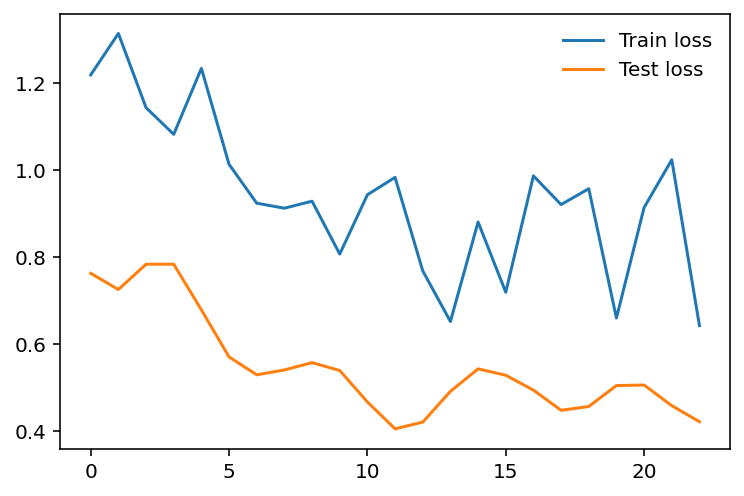

In [ ]:
plt.plot(train_losses, label = 'Train loss')
plt.plot(test_losses, label = 'Test loss')
plt.legend(frameon = False)

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

In [ ]:
def show_predictions(model, class_names, n_images=6):
    model = model.eval()
    images_handeled = 0
    plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.shape[0]):
                images_handeled += 1
                ax = plt.subplot(2, n_images//2, images_handeled)
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                ax.axis('off')

                if images_handeled == n_images:
                    return

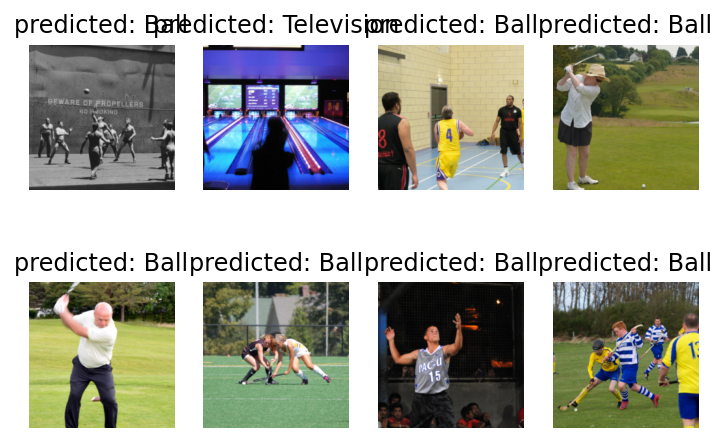

In [ ]:
show_predictions(model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds)
            real_values.extend(labels)
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(model, testloader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Ball       0.88      0.69      0.77       697
     Balloon       0.79      0.85      0.82       653
       Bench       0.80      0.91      0.85       727
      Castle       0.97      0.98      0.98       748
         Cat       0.98      0.98      0.98      4000
      Coffee       0.57      0.32      0.41       372
  Coffee cup       0.63      0.83      0.72       759
Coffee table       0.80      0.23      0.36       569
       Couch       0.51      0.80      0.62       665
         Dog       0.97      0.98      0.98      4000
    Elephant       0.73      0.87      0.79       347
  Helicopter       0.85      0.92      0.88       480
  Television       0.93      0.71      0.81       558
      Weapon       0.88      0.51      0.65       330

    accuracy                           0.87     14905
   macro avg       0.81      0.76      0.76     14905
weighted avg       0.88      0.87      0.87     14905



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

    cm = confusion_matrix.copy()

    cell_counts = cm.flatten()

    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Sign')
    plt.xlabel('Predicted Sign');

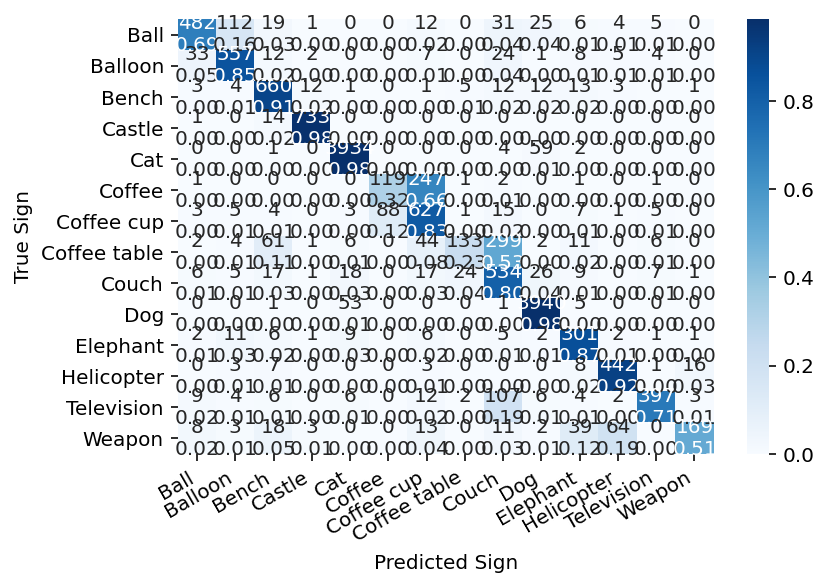

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)